# Tech Challenge - Fase 2

Participantes:
    
- Gustavo França - RM351418
- Victor Lamana - RM351187
- Jeferson Vieira - RM351905

Para tentar chegar a predição com um acerto de 70% fizemos várias tentativa de vários modelos, inclusive variando os parâmetros.

Abaixo segue nossas tentativas junto das justificativas de não os utilizarmos e ao final o modelo final.

# Importação de bibliotecas

In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn import metrics
from prophet.plot import add_changepoints_to_plot,plot_cross_validation_metric
from prophet.diagnostics import performance_metrics,cross_validation
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose



import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

# Modelo 1 - Prophet com base de teste aleatória

In [4]:
# Symbol da Ibovespa e o intervalo de tempo
symbol = '^BVSP'
start_date = '2017-01-01'
end_date = '2023-12-31'

# Download do yf
df = yf.download(symbol, start=start_date, end=end_date)
df.index = pd.to_datetime(df.index)  # Certifique-se de que o índice seja do tipo DatetimeIndex
df = df.asfreq('B')  # Defina a frequência como diária (ou ajuste para a frequência apropriada)

df_original = yf.download(symbol, start=start_date, end=end_date)
df_original.index = pd.to_datetime(df_original.index)  # Certifique-se de que o índice seja do tipo DatetimeIndex

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
df.reset_index(inplace=True)
df = df[['Date','Close']]
df[['ds','y']] = df[['Date','Close']]
df.drop(columns=['Date','Close'], inplace=True)

In [6]:
m = Prophet()
m.add_country_holidays(country_name='BR')

In [7]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1733 entries, 0 to 1823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1733 non-null   datetime64[ns]
 1   y       1733 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.6 KB


In [8]:
df

,ds,y
0,2017-01-02,59589.0
1,2017-01-03,61814.0
2,2017-01-04,61589.0
3,2017-01-05,62071.0
4,2017-01-06,61665.0
...,...,...
1818,2023-12-21,132182.0
1819,2023-12-22,132753.0
1821,2023-12-26,133533.0
1822,2023-12-27,134194.0


Aqui nós vamos realizar um treino com uma fração aleatória dos dados, isso tende a ser um pouco mais eficaz que a separação por data pois mistura dados e registros de diversas janelas de tempo.

In [9]:
train_set = df.sample(frac=0.8, random_state=0)
test_set = df.drop(train_set.index)
print(f'training data size : {train_set.shape}')
print(f'testing data size : {test_set.shape}')

training data size : (1386, 2)
testing data size : (347, 2)


In [10]:
m=Prophet(holidays_prior_scale=0,seasonality_prior_scale=20,changepoint_prior_scale=0.01)
m.fit(train_set)

23:10:32 - cmdstanpy - INFO - Chain [1] start processing
23:10:32 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-17,62559.045143,58293.319155,78254.322280,62559.045143,62559.045143,5308.729771,5308.729771,5308.729771,728.401745,728.401745,728.401745,4580.328027,4580.328027,4580.328027,0.0,0.0,0.0,67867.774914
1,2017-02-03,63186.496886,58306.541992,78531.069894,63186.496886,63186.496886,5225.347022,5225.347022,5225.347022,473.152406,473.152406,473.152406,4752.194616,4752.194616,4752.194616,0.0,0.0,0.0,68411.843908
2,2017-02-06,63297.223665,58270.545448,78449.527496,63297.223665,63297.223665,5139.092379,5139.092379,5139.092379,433.847266,433.847266,433.847266,4705.245113,4705.245113,4705.245113,0.0,0.0,0.0,68436.316043
3,2017-02-07,63334.132591,58436.948456,78480.319037,63334.132591,63334.132591,5427.208939,5427.208939,5427.208939,728.401745,728.401745,728.401745,4698.807195,4698.807195,4698.807195,0.0,0.0,0.0,68761.341530
4,2017-02-10,63444.859369,58817.952509,77754.471047,63444.859369,63444.859369,5169.082169,5169.082169,5169.082169,473.152406,473.152406,473.152406,4695.929763,4695.929763,4695.929763,0.0,0.0,0.0,68613.941538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2023-11-16,114315.010824,105645.575855,126381.641010,114315.010824,114315.010824,1280.503518,1280.503518,1280.503518,599.940042,599.940042,599.940042,680.563476,680.563476,680.563476,0.0,0.0,0.0,115595.514342
343,2023-11-21,114336.418705,106919.769450,126446.105561,114336.418705,114336.418705,1959.792515,1959.792515,1959.792515,728.401745,728.401745,728.401745,1231.390770,1231.390770,1231.390770,0.0,0.0,0.0,116296.211220
344,2023-12-06,114400.642349,106910.765995,126974.428020,114400.642349,114400.642349,2713.486991,2713.486991,2713.486991,191.503503,191.503503,191.503503,2521.983488,2521.983488,2521.983488,0.0,0.0,0.0,117114.129341
345,2023-12-20,114460.584417,106660.536066,127318.798088,114460.584417,114460.584417,2246.268653,2246.268653,2246.268653,191.503503,191.503503,191.503503,2054.765150,2054.765150,2054.765150,0.0,0.0,0.0,116706.853070


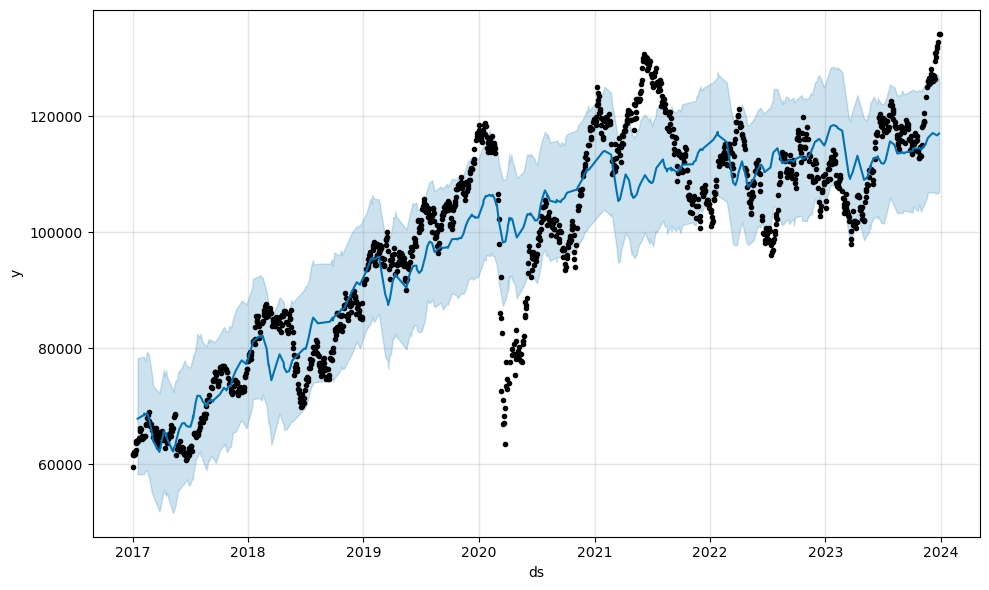

In [11]:
y_pred=m.predict(test_set)
m.plot(y_pred);
y_pred

In [12]:
print('MAE: {}'.format(metrics.mean_absolute_error(test_set['y'].values,y_pred['yhat'].values)))
print('RMSE: {}'.format(metrics.mean_squared_error(test_set['y'].values,y_pred['yhat'].values,squared=False)))

MAE: 6438.335572609635
RMSE: 8412.982052784891


O MAE é uma métrica que representa a média absoluta das diferenças entre as previsões do modelo e os valores reais. No seu caso, o valor do MAE é aproximadamente 4608.51. Isso significa que, em média, as previsões do seu modelo estão distantes dos valores reais por cerca de 4608.51 unidades na mesma escala dos dados originais.

O RMSE é uma métrica que leva em consideração a magnitude dos erros quadráticos. No seu caso, o valor do RMSE é aproximadamente 5966.58. Isso indica que, em média, as previsões do modelo estão distantes dos valores reais por cerca de 5966.58 unidades, penalizando erros maiores de forma mais significativa.

<Axes: xlabel='ds'>

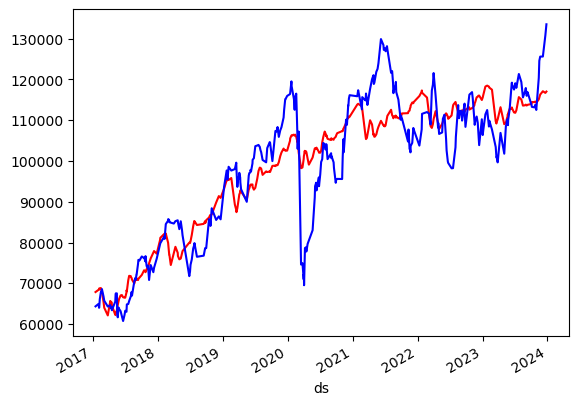

In [13]:
y_pred.set_index('ds')['yhat'].plot(color='red')
test_set.set_index('ds')['y'].plot(color='blue')

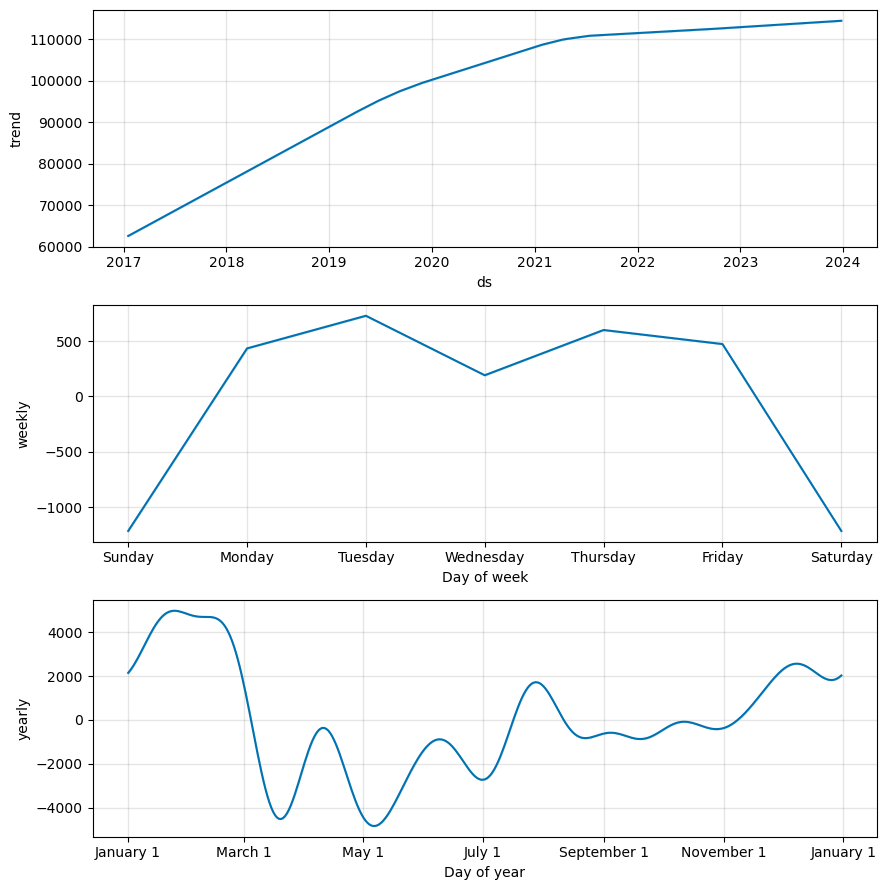

In [14]:
decompos = m.plot_components(y_pred)

Prevendo o futuro com o modelo Prophet

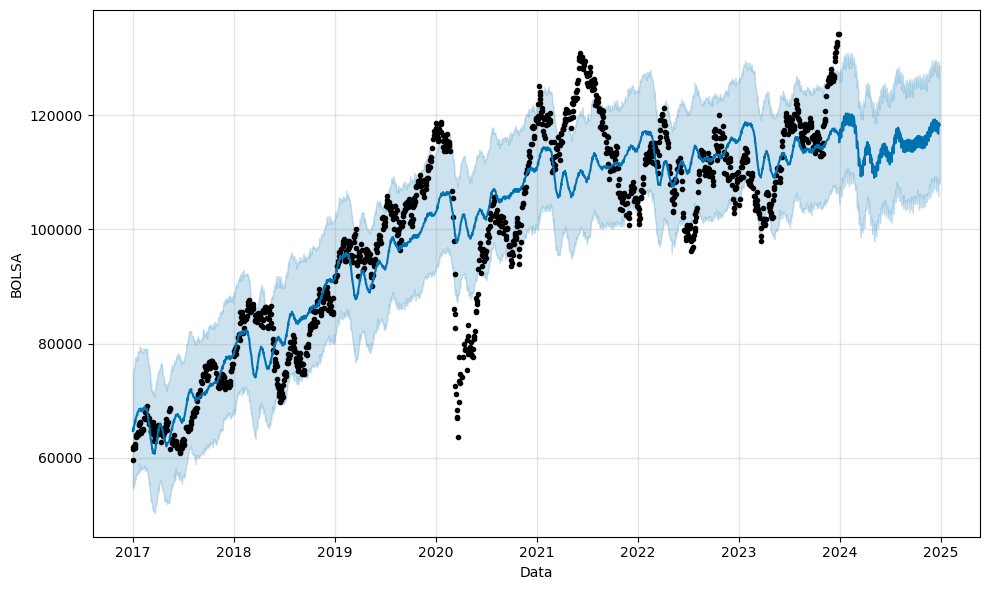

In [15]:
# determinar o período de dias para previsão
future = m.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = m.predict(future)

m.plot(forecast, xlabel='Data', ylabel='BOLSA');

In [16]:
print('MAE: {}'.format(metrics.mean_absolute_error(test_set['y'].values,y_pred['yhat'].values)))
print('RMSE: {}'.format(metrics.mean_squared_error(test_set['y'].values,y_pred['yhat'].values,squared=False)))

mae = mean_absolute_error(test_set['y'], y_pred['yhat'])
mse = mean_squared_error(test_set['y'], y_pred['yhat'])
rmse = np.sqrt(mse)
wmape1 = wmape(test_set['y'].values, y_pred['yhat'].values)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print(f"WMAPE: {wmape1:.2%}")

MAE: 6438.335572609635
RMSE: 8412.982052784891
MAE: 6438.335572609635
MSE: 70778267.02048068
RMSE: 8412.982052784891
WMAPE: 6.56%


Apesar do WMAPE ser aceitável talvez conseguimos melhorar essa porcentagem de erro. Neste modelo não alteramos nenhum parâmetro padrão do modelo Prophet.

# Modelo 2 - Prophet com estacionarização por diferenciação

In [18]:
sns.set_style('darkgrid')

In [19]:
df_estac = df

In [20]:
X = df_estac.y.values
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.7660878371062592
P-Value: 0.39742330745907145
Valores críticos:
	1%: -3.4341487606638452
	5%: -2.863217940480328
	10%: -2.5676632884862807


Diagnosticada que série não é estacionaria pois o p-value é maior que 0,05

In [21]:
# Aplicar a primeira diferenciação
df_estac['y_diff1'] = df_estac['y'].diff()

# Remover a primeira observação (NaN resultante da primeira diferenciação)
df_estac = df_estac.dropna()

In [22]:
# Aplicar o teste ADF na primeira diferenciação
result_diff1 = adfuller(df_estac['y_diff1'])
print("Teste ADF após a primeira diferenciação:")
print(f"Teste Estatístico: {result_diff1[0]}")
print(f"P-Value: {result_diff1[1]}")
print("Valores críticos:")
for key, value in result[4].items():
  print(f"\t{key}: {value}")
  
if result_diff1[1] < 0.05:
  print("Série estacionária!")
else:
  print("Série não estacionária!")

Teste ADF após a primeira diferenciação:
Teste Estatístico: -13.058853515888835
P-Value: 2.0674808076841547e-24
Valores críticos:
	1%: -3.4341487606638452
	5%: -2.863217940480328
	10%: -2.5676632884862807
Série estacionária!


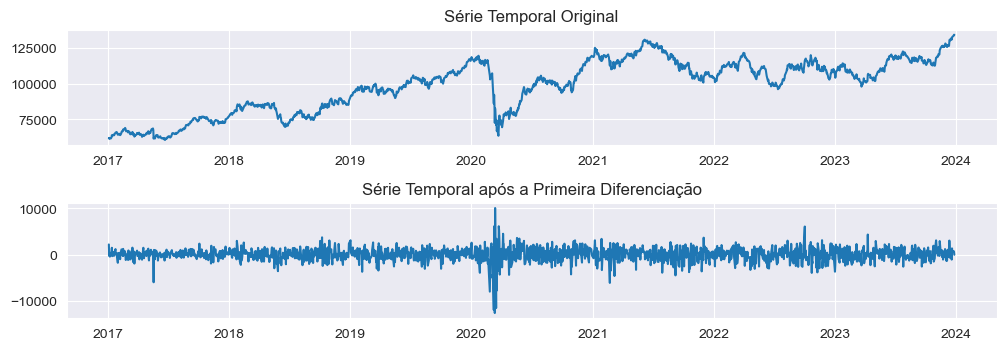

In [23]:
# Plotar a série original
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(df_estac['ds'], df_estac['y'])
plt.title('Série Temporal Original')

# Plotar a série após a primeira diferenciação
plt.subplot(3, 1, 2)
plt.plot(df_estac['ds'], df_estac['y_diff1'])
plt.title('Série Temporal após a Primeira Diferenciação')

plt.subplots_adjust(hspace=0.5)

In [24]:
# Dropar a coluna 'y'
df_estacfim = df_estac.drop(columns=['y'])

# Renomear 'y_diff1' para 'y'
df_estacfim = df_estacfim.rename(columns={'y_diff1': 'y'})

df_estacfim

,ds,y
1,2017-01-03,2225.0
2,2017-01-04,-225.0
3,2017-01-05,482.0
4,2017-01-06,-406.0
5,2017-01-09,35.0
...,...,...
1818,2023-12-21,1378.0
1819,2023-12-22,571.0
1821,2023-12-26,780.0
1822,2023-12-27,661.0


In [25]:
# Defina a proporção desejada para a amostragem (por exemplo, 80% para treino)
proporcao_treino = 0.8

# Calcule o índice onde a divisão ocorrerá
indice_divisao = int(len(df_estacfim) * proporcao_treino)

# Separe o DataFrame continuamente
train_set3 = df_estacfim.iloc[:indice_divisao]
test_set3 = df_estacfim.iloc[indice_divisao:]

print(f'training data size : {train_set3.shape}')
print(f'testing data size : {test_set3.shape}')

training data size : (1385, 2)
testing data size : (347, 2)


23:18:24 - cmdstanpy - INFO - Chain [1] start processing
23:18:24 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-08-09,340.540425,-1881.919923,1981.210727,340.540425,340.540425,-279.128980,-279.128980,-279.128980,-169.419318,-169.419318,-169.419318,-109.709661,-109.709661,-109.709661,0.0,0.0,0.0,61.411446
1,2022-08-10,340.487708,-1974.677762,1870.073566,340.487708,340.487708,-422.839232,-422.839232,-422.839232,-312.810363,-312.810363,-312.810363,-110.028869,-110.028869,-110.028869,0.0,0.0,0.0,-82.351524
2,2022-08-11,340.434991,-2082.554996,1747.376609,340.434991,340.434991,-532.534988,-532.534988,-532.534988,-423.476684,-423.476684,-423.476684,-109.058303,-109.058303,-109.058303,0.0,0.0,0.0,-192.099996
3,2022-08-12,340.382274,-2089.315081,1699.857811,340.382274,340.382274,-507.058933,-507.058933,-507.058933,-400.159425,-400.159425,-400.159425,-106.899508,-106.899508,-106.899508,0.0,0.0,0.0,-166.676659
4,2022-08-15,340.224123,-2078.945217,1602.785464,340.224123,340.224123,-565.118110,-565.118110,-565.118110,-470.643351,-470.643351,-470.643351,-94.474759,-94.474759,-94.474759,0.0,0.0,0.0,-224.893987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2023-12-21,314.234589,-1708.413344,1834.684619,314.234072,314.235129,-268.155846,-268.155846,-268.155846,-423.476684,-423.476684,-423.476684,155.320839,155.320839,155.320839,0.0,0.0,0.0,46.078743
343,2023-12-22,314.181872,-1749.246023,2002.933703,314.181353,314.182413,-223.618836,-223.618836,-223.618836,-400.159425,-400.159425,-400.159425,176.540589,176.540589,176.540589,0.0,0.0,0.0,90.563036
344,2023-12-26,313.971004,-1446.205484,2249.307892,313.970482,313.971547,95.926872,95.926872,95.926872,-169.419318,-169.419318,-169.419318,265.346191,265.346191,265.346191,0.0,0.0,0.0,409.897876
345,2023-12-27,313.918287,-1700.603840,2162.750419,313.917763,313.918831,-26.847395,-26.847395,-26.847395,-312.810363,-312.810363,-312.810363,285.962968,285.962968,285.962968,0.0,0.0,0.0,287.070892


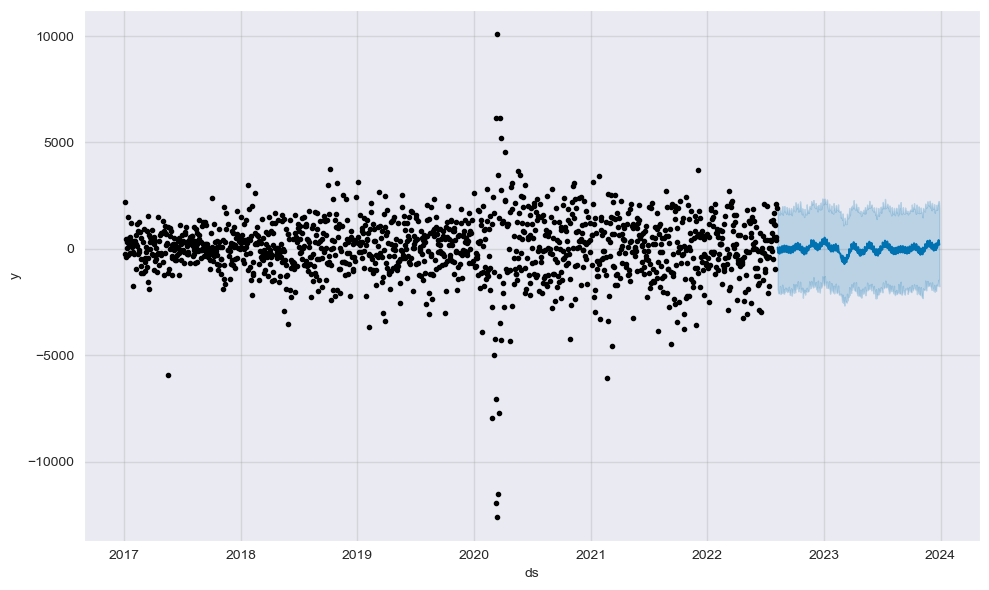

In [26]:
#Instanciando modelo
m3=Prophet()
m3.fit(train_set3)

#Prevendo base test_set
y_pred3=m3.predict(test_set3)
m3.plot(y_pred3);
y_pred3

<Axes: xlabel='ds'>

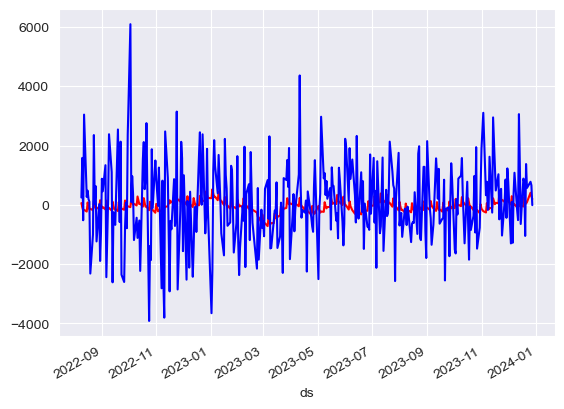

In [27]:
y_pred3.set_index('ds')['yhat'].plot(color='red')
test_set3.set_index('ds')['y'].plot(color='blue')

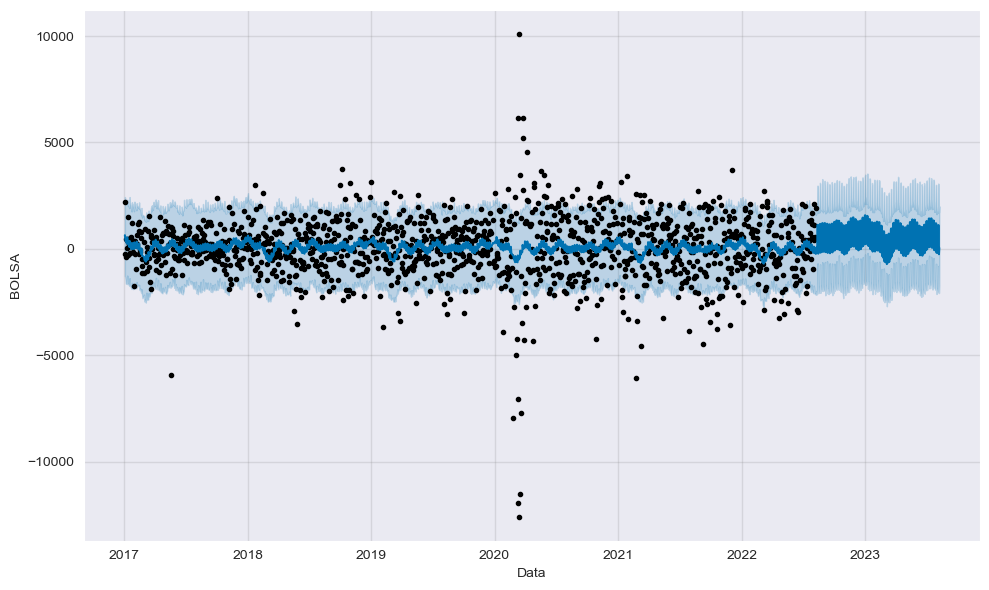

In [28]:
# determinar o período de dias para previsão
future = m3.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = m3.predict(future)

m3.plot(forecast, xlabel='Data', ylabel='BOLSA');

In [29]:
mae = mean_absolute_error(test_set3['y'], y_pred3['yhat'])
mse = mean_squared_error(test_set3['y'], y_pred3['yhat'])
rmse = np.sqrt(mse)
wmape1 = wmape(test_set3['y'].values, y_pred3['yhat'].values)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print(f"WMAPE: {wmape1:.2%}")

MAE: 1074.7045405595711
MSE: 1907596.2210311743
RMSE: 1381.1575656061746
WMAPE: 99.55%


Este modelo ficou com um WMAPE extremamente alto, portanto tentaremos uma outra alternativa de suavização.

# Modelo 3 - Prophet com estacionarização por suavização exponencial

A suavização exponencial é uma técnica que atribui pesos decrescentes exponencialmente aos valores anteriores. Pode ser útil para remover padrões sazonais.

In [31]:
df_estacexp = df

In [32]:
X = df_estacexp.y.values
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.7660878371062592
P-Value: 0.39742330745907145
Valores críticos:
	1%: -3.4341487606638452
	5%: -2.863217940480328
	10%: -2.5676632884862807


Diagnosticada que série não é estacionaria pois o p-value é maior que 0,05

In [33]:
model = ExponentialSmoothing(df_estacexp['y'])
result = model.fit()
df_estacexp['y_smoothed'] = result.fittedvalues

C:\Users\Gustavo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [34]:
# Aplicar o teste ADF na primeira diferenciação
result_diff1 = adfuller(df_estacexp['y_smoothed'])
print("Teste ADF após suavização exponencial:")
print(f"Teste Estatístico: {result_diff1[0]}")
print(f"P-Value: {result_diff1[1]}")
  
if result_diff1[1] < 0.05:
  print("Série estacionária!")
else:
  print("Série não estacionária!")

Teste ADF após suavização exponencial:
Teste Estatístico: -1.783043702025646
P-Value: 0.38891192356523535
Série não estacionária!


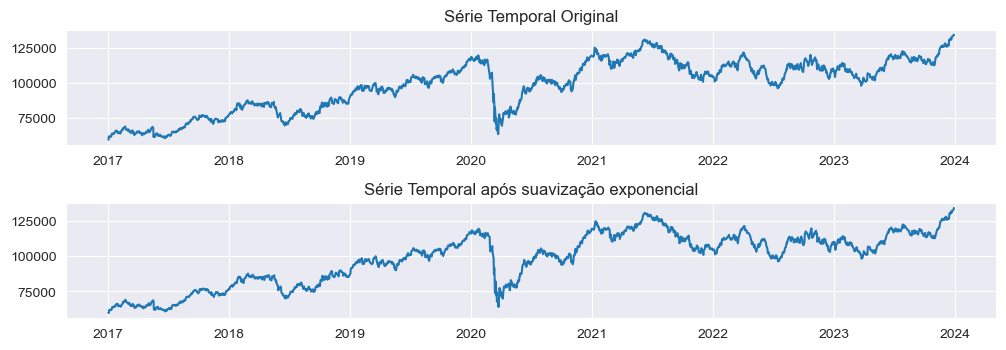

In [35]:
# Plotar a série original
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(df_estacexp['ds'], df_estacexp['y'])
plt.title('Série Temporal Original')

# Plotar a série após a primeira diferenciação
plt.subplot(3, 1, 2)
plt.plot(df_estacexp['ds'], df_estacexp['y_smoothed'])
plt.title('Série Temporal após suavização exponencial')

plt.subplots_adjust(hspace=0.5)

Como não conseguimos transformar a série em estacionária não seguiremos com esse método.

# Modelo 4 - Prophet com timeframe da base de teste reduzida

In [45]:
# Symbol da Ibovespa e o intervalo de tempo
symbol = '^BVSP'
start_date = '2023-10-01'
end_date = '2023-12-31'

# Download do yf
df = yf.download(symbol, start=start_date, end=end_date)
df.index = pd.to_datetime(df.index)  # Certifique-se de que o índice seja do tipo DatetimeIndex
#df = df.asfreq('B')  # Defina a frequência como diária (ou ajuste para a frequência apropriada)

[*********************100%%**********************]  1 of 1 completed


In [46]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-02,116565.0,116672.0,114761.0,115057.0,115057.0,8524900
2023-10-03,115055.0,115056.0,113151.0,113419.0,113419.0,11104800
2023-10-04,113430.0,114075.0,113036.0,113607.0,113607.0,10813800
2023-10-05,113609.0,114359.0,112705.0,113284.0,113284.0,9507200
2023-10-06,113283.0,114491.0,111599.0,114170.0,114170.0,13138200
2023-10-09,114169.0,115219.0,113448.0,115156.0,115156.0,9474400
2023-10-10,115158.0,116900.0,115158.0,116737.0,116737.0,11621500
2023-10-11,116737.0,117099.0,116231.0,117051.0,117051.0,9949800
2023-10-13,117050.0,117070.0,115658.0,115754.0,115754.0,10609300


In [47]:
df.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True, axis=1)

In [48]:
df.reset_index(inplace=True)
df.columns = ['ds','y']

In [49]:
df.head(10)

,ds,y
0,2023-10-02,115057.0
1,2023-10-03,113419.0
2,2023-10-04,113607.0
3,2023-10-05,113284.0
4,2023-10-06,114170.0
5,2023-10-09,115156.0
6,2023-10-10,116737.0
7,2023-10-11,117051.0
8,2023-10-13,115754.0
9,2023-10-16,116534.0


In [50]:
df.isna().count()

ds    60
y     60
dtype: int64

In [51]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      60 non-null     datetime64[ns]
 1   y       60 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [52]:
df.head(10)

,ds,y
0,2023-10-02,115057.0
1,2023-10-03,113419.0
2,2023-10-04,113607.0
3,2023-10-05,113284.0
4,2023-10-06,114170.0
5,2023-10-09,115156.0
6,2023-10-10,116737.0
7,2023-10-11,117051.0
8,2023-10-13,115754.0
9,2023-10-16,116534.0


In [53]:
# Defina a proporção desejada para a amostragem (por exemplo, 80% para treino)
proporcao_treino = 0.95

# Calcule o índice onde a divisão ocorrerá
indice_divisao = int(len(df) * proporcao_treino)

# Separe o DataFrame continuamente
train_set = df.iloc[:indice_divisao]
test_set = df.iloc[indice_divisao:]

print(f'Training data size : {train_set.shape}')
print(f'Testing data size : {test_set.shape}')

Training data size : (57, 2)
Testing data size : (3, 2)


23:29:35 - cmdstanpy - INFO - Chain [1] start processing
23:29:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-12-26,82773.530801,132277.242298,134636.441423,82760.988693,82797.883717,50684.162339,50684.162339,50684.162339,50684.162339,50684.162339,50684.162339,0.0,0.0,0.0,133457.693139
1,2023-12-27,83107.938328,132342.190074,134709.863374,83042.964613,83186.697939,50446.322517,50446.322517,50446.322517,50446.322517,50446.322517,50446.322517,0.0,0.0,0.0,133554.260845
2,2023-12-28,83442.345854,133113.304981,135530.077488,83287.520208,83603.738098,50854.753734,50854.753734,50854.753734,50854.753734,50854.753734,50854.753734,0.0,0.0,0.0,134297.099588


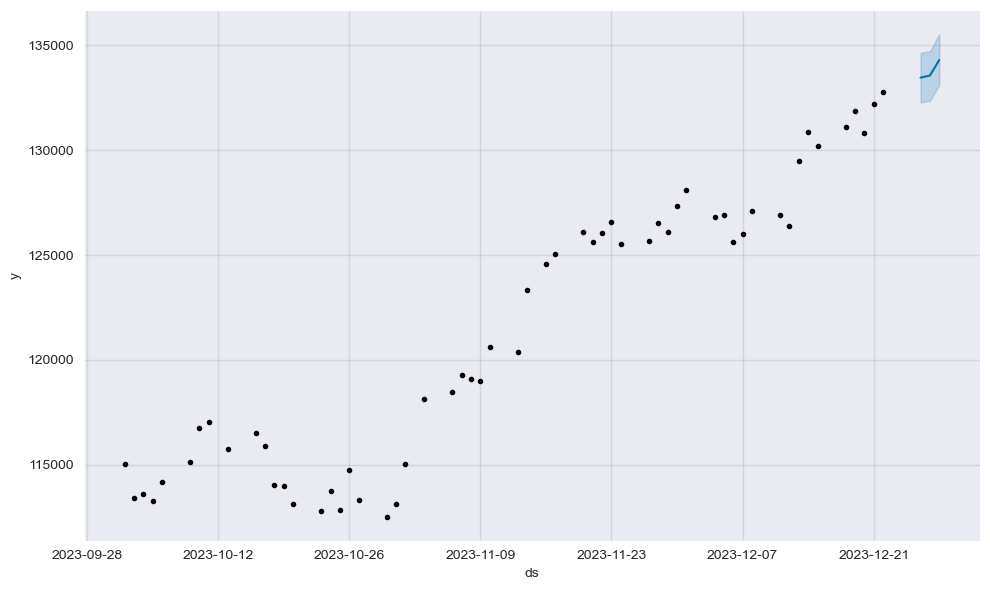

In [54]:
#Instanciando modelo
prophetModel = Prophet()
prophetModel.fit(train_set)

#Prevendo base test_set
y_pred = prophetModel.predict(test_set)
prophetModel.plot(y_pred);
y_pred

<Axes: xlabel='ds'>

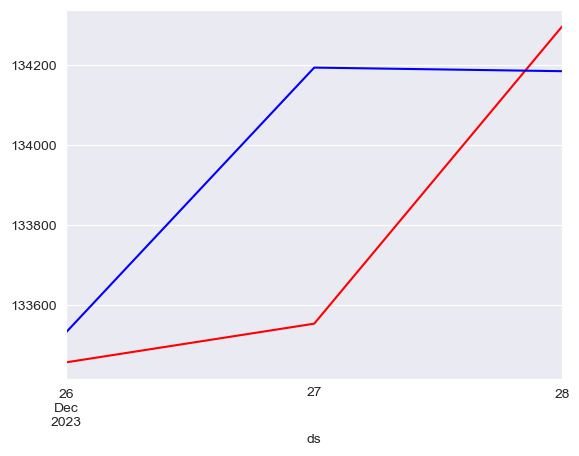

In [55]:
y_pred.set_index('ds')['yhat'].plot(color='red')
test_set.set_index('ds')['y'].plot(color='blue')

In [56]:
print('MAE: {}'.format(metrics.mean_absolute_error(test_set['y'].values,y_pred['yhat'].values)))
print('RMSE: {}'.format(metrics.mean_squared_error(test_set['y'].values,y_pred['yhat'].values,squared=False)))

mae = mean_absolute_error(test_set['y'], y_pred['yhat'])
mse = mean_squared_error(test_set['y'], y_pred['yhat'])
rmse = np.sqrt(mse)
wmape = wmape(test_set['y'].values, y_pred['yhat'].values)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print(f"WMAPE: {wmape:.2%}")

MAE: 275.715201460281
RMSE: 377.4933235460323
MAE: 275.715201460281
MSE: 142501.20932182943
RMSE: 377.4933235460323
WMAPE: 0.21%


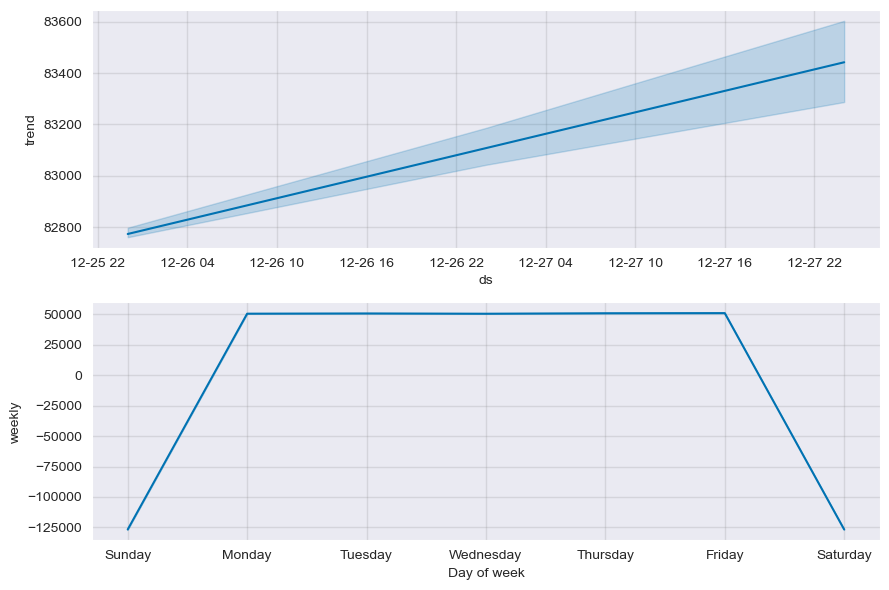

In [57]:
decompose = prophetModel.plot_components(y_pred)

A primeira vista esse modelo parece perfeito pois a diferença da média de erro encontrada no primeiro modelo sugere algo em torno de 6000 pontos de diferença para a cotação real, o que em termos financeiro é extremamente significativo, e esse último modelo sugere uma média de erro de 275 pontos. 

Porém algumas coisas devem ser observadas. 

Primeiro: quanto ao período utilizado. O curto espaço de tempo utilizado no treinamento pode fazer com que tenhamos o problema de overfitting.

Segundo: quanto ao número de dias da predição. Essa predição tráz valores para curtíssimo prazo.

# Modelo 5 - Prophet com base de treino aleatória com novos parâmetros

In [58]:
# Symbol da Ibovespa e o intervalo de tempo
symbol = '^BVSP'
start_date = '2017-01-01'
end_date = '2023-12-12'

# Download do yf
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [59]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,60227.0,60227.0,59371.0,59589.0,59589.0,808700
2017-01-03,59631.0,61815.0,59631.0,61814.0,61814.0,3328300
2017-01-04,61811.0,61940.0,61302.0,61589.0,61589.0,2840800
2017-01-05,61594.0,62409.0,61594.0,62071.0,62071.0,3313000
2017-01-06,62072.0,62072.0,61396.0,61665.0,61665.0,2374800


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1721 entries, 2017-01-02 to 2023-12-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1721 non-null   float64
 1   High       1721 non-null   float64
 2   Low        1721 non-null   float64
 3   Close      1721 non-null   float64
 4   Adj Close  1721 non-null   float64
 5   Volume     1721 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 94.1 KB


In [61]:
df= df.reset_index('Date')

In [62]:
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime

In [64]:
df_bvsp = df # backup do dataset original

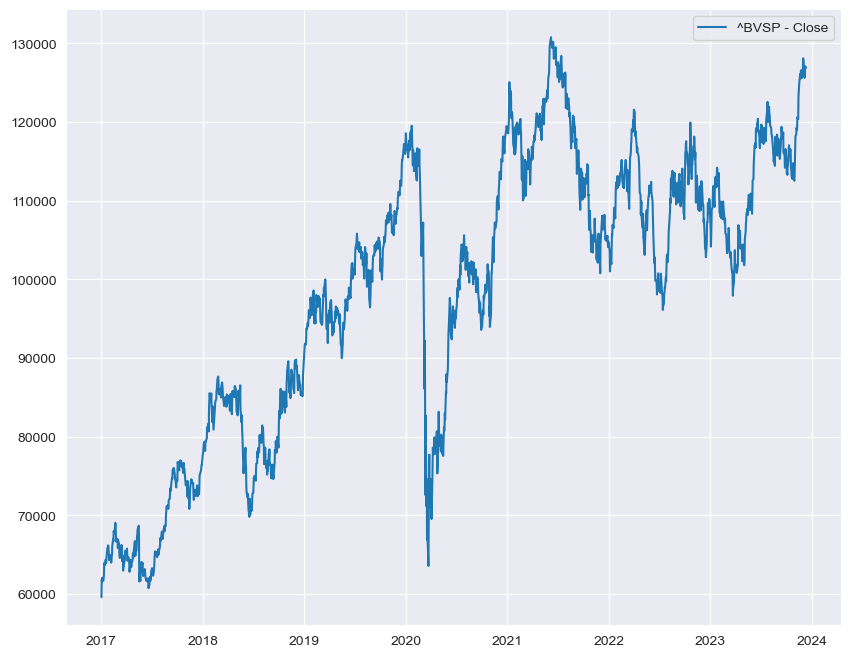

In [65]:
plt.figure(figsize = (10,8))
plt.plot(df['Date'], df['Close'], label='^BVSP - Close')

plt.legend(loc='best')
plt.show()

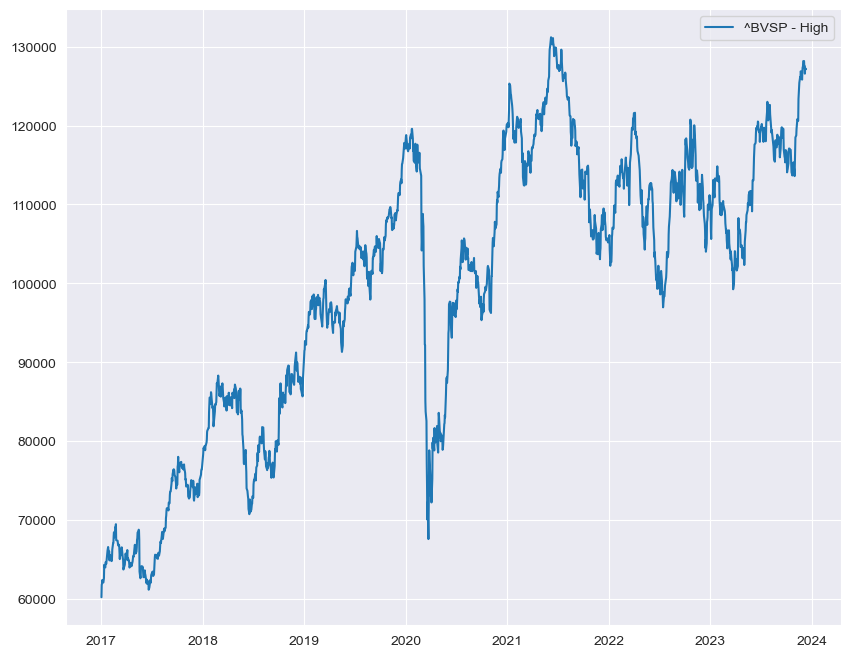

In [66]:
plt.figure(figsize = (10,8))
plt.plot(df['Date'], df['High'], label='^BVSP - High')

plt.legend(loc='best')
plt.show()

In [67]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,60227.0,60227.0,59371.0,59589.0,59589.0,808700
1,2017-01-03,59631.0,61815.0,59631.0,61814.0,61814.0,3328300
2,2017-01-04,61811.0,61940.0,61302.0,61589.0,61589.0,2840800
3,2017-01-05,61594.0,62409.0,61594.0,62071.0,62071.0,3313000
4,2017-01-06,62072.0,62072.0,61396.0,61665.0,61665.0,2374800


Prophet é uma biblioteca em Python para previsão de séries temporais. Ela foi desenvolvida pela equipe de Ciência de Dados do Facebook e oferece uma abordagem automatizada para prever dados de séries temporais com base em um modelo aditivo. Aqui estão algumas das principais funcionalidades do Prophet:

Modelagem Automatizada: O Prophet é projetado para fazer previsões automaticamente, sem a necessidade de ajustes manuais complexos. Ele detecta tendências não lineares e sazonalidades anuais, semanais e diárias nos dados de séries temporais.

Robustez: O Prophet lida bem com dados ausentes e mudanças nas tendências. Ele também é capaz de lidar com valores atípicos de forma eficaz.

Sazonalidade: O modelo do Prophet incorpora sazonalidades, como feriados, que podem afetar os dados de séries temporais.

Histórico de Dados: O Prophet funciona melhor quando há várias temporadas de dados históricos disponíveis.

In [68]:
df.drop(columns=['Open', 'Low', 'Volume', 'Adj Close','High'], inplace=True)

In [69]:
df[['ds','y']] = df[['Date','Close']]  # ds e y é o mínimo para uma previsão de serie temporal, coloquei mais uma feature que é o High
df.head()

,Date,Close,ds,y
0,2017-01-02,59589.0,2017-01-02,59589.0
1,2017-01-03,61814.0,2017-01-03,61814.0
2,2017-01-04,61589.0,2017-01-04,61589.0
3,2017-01-05,62071.0,2017-01-05,62071.0
4,2017-01-06,61665.0,2017-01-06,61665.0


In [70]:
#Treino e teste
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (1377, 4)
testing data size : (344, 4)


In [71]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=365, freq='D')  # diário com forecast de 365 dias
previsao = modelo.predict(dataFramefuture)
previsao.head()

23:42:55 - cmdstanpy - INFO - Chain [1] start processing
23:42:55 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-02,59344.579488,56137.044073,69495.121167,59344.579488,59344.579488,3375.310705,3375.310705,3375.310705,1160.631769,...,50.979239,50.979239,50.979239,2163.699698,2163.699698,2163.699698,0.0,0.0,0.0,62719.890193
1,2017-01-03,59387.924404,56000.056845,70801.859269,59387.924404,59387.924404,3868.095726,3868.095726,3868.095726,1160.631769,...,306.466208,306.466208,306.466208,2400.997748,2400.997748,2400.997748,0.0,0.0,0.0,63256.020129
2,2017-01-04,59431.269319,55851.475052,70429.332942,59431.269319,59431.269319,3703.909375,3703.909375,3703.909375,1160.631769,...,-97.524856,-97.524856,-97.524856,2640.802463,2640.802463,2640.802463,0.0,0.0,0.0,63135.178695
3,2017-01-05,59474.614235,56652.960757,70855.613692,59474.614235,59474.614235,4036.346876,4036.346876,4036.346876,1160.631769,...,-4.878664,-4.878664,-4.878664,2880.593771,2880.593771,2880.593771,0.0,0.0,0.0,63510.961111
4,2017-01-06,59517.959150,57112.242532,70553.471581,59517.959150,59517.959150,4313.655412,4313.655412,4313.655412,1160.631769,...,35.116830,35.116830,35.116830,3117.906812,3117.906812,3117.906812,0.0,0.0,0.0,63831.614562


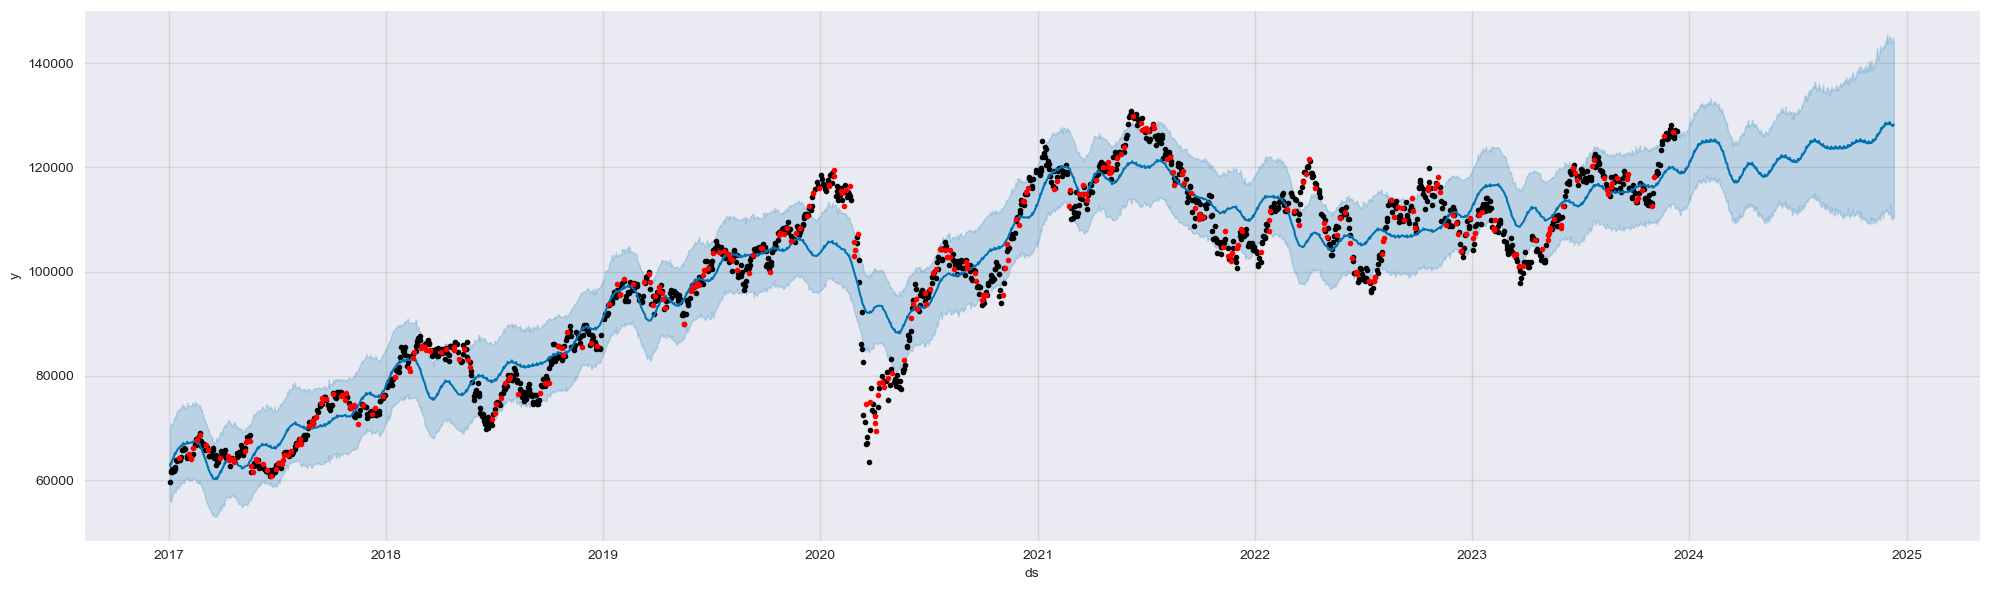

In [72]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

In [73]:
previsao.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1737,2024-12-06,125755.650839,110034.742654,143772.761129,110083.638727,140013.368042,2517.472037,2517.472037,2517.472037,1160.631769,...,35.116830,35.116830,35.116830,1321.723438,1321.723438,1321.723438,0.0,0.0,0.0,128273.122876
1738,2024-12-07,125779.012494,110798.278653,143952.906049,110042.376079,140112.588099,2240.006100,2240.006100,2240.006100,1160.631769,...,-145.079313,-145.079313,-145.079313,1224.453644,1224.453644,1224.453644,0.0,0.0,0.0,128019.018594
1739,2024-12-08,125802.374148,110273.811817,144296.756944,110002.810076,140211.808155,2136.496634,2136.496634,2136.496634,1160.631769,...,-145.079444,-145.079444,-145.079444,1120.944309,1120.944309,1120.944309,0.0,0.0,0.0,127938.870782
1740,2024-12-09,125825.735803,110319.155225,145037.545868,109967.577602,140311.028212,2225.211477,2225.211477,2225.211477,1160.631769,...,50.979239,50.979239,50.979239,1013.600470,1013.600470,1013.600470,0.0,0.0,0.0,128050.947281
1741,2024-12-10,125849.097458,110233.696793,143704.870028,109927.977564,140410.248269,2372.025937,2372.025937,2372.025937,1160.631769,...,306.466208,306.466208,306.466208,904.927960,904.927960,904.927960,0.0,0.0,0.0,128221.123395


In [74]:
previsao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1742 entries, 0 to 1741
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          1742 non-null   datetime64[ns]
 1   trend                       1742 non-null   float64       
 2   yhat_lower                  1742 non-null   float64       
 3   yhat_upper                  1742 non-null   float64       
 4   trend_lower                 1742 non-null   float64       
 5   trend_upper                 1742 non-null   float64       
 6   additive_terms              1742 non-null   float64       
 7   additive_terms_lower        1742 non-null   float64       
 8   additive_terms_upper        1742 non-null   float64       
 9   daily                       1742 non-null   float64       
 10  daily_lower                 1742 non-null   float64       
 11  daily_upper                 1742 non-null   float64     

In [75]:
filtered_df = previsao[(previsao['ds'] >=  '2023-02-13') & (previsao['ds'] <= '2023-12-15')]
filtered_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1206,2023-02-13,110290.235507,109019.832265,123917.391601,110290.235507,110290.235507,6317.837145,6317.837145,6317.837145,1160.631769,...,50.979239,50.979239,50.979239,5106.226138,5106.226138,5106.226138,0.0,0.0,0.0,116608.072652
1207,2023-02-14,110313.597162,109639.553111,123626.184880,110313.597162,110313.597162,6513.332928,6513.332928,6513.332928,1160.631769,...,306.466208,306.466208,306.466208,5046.234950,5046.234950,5046.234950,0.0,0.0,0.0,116826.930089
1208,2023-02-15,110336.958816,109348.812316,123665.180240,110336.958816,110336.958816,6034.241647,6034.241647,6034.241647,1160.631769,...,-97.524856,-97.524856,-97.524856,4971.134734,4971.134734,4971.134734,0.0,0.0,0.0,116371.200463
1209,2023-02-16,110360.320471,109011.823596,123684.267988,110360.320471,110360.320471,6034.784056,6034.784056,6034.784056,1160.631769,...,-4.878664,-4.878664,-4.878664,4879.030951,4879.030951,4879.030951,0.0,0.0,0.0,116395.104526
1210,2023-02-17,110383.682125,109235.710152,123274.725606,110383.682125,110383.682125,5963.915420,5963.915420,5963.915420,1160.631769,...,35.116830,35.116830,35.116830,4768.166821,4768.166821,4768.166821,0.0,0.0,0.0,116347.597545


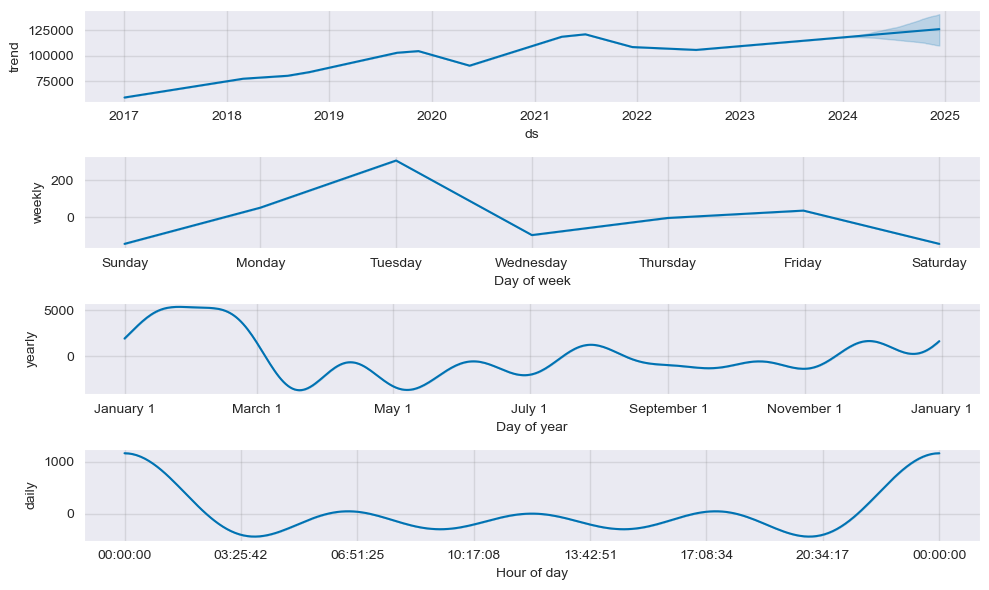

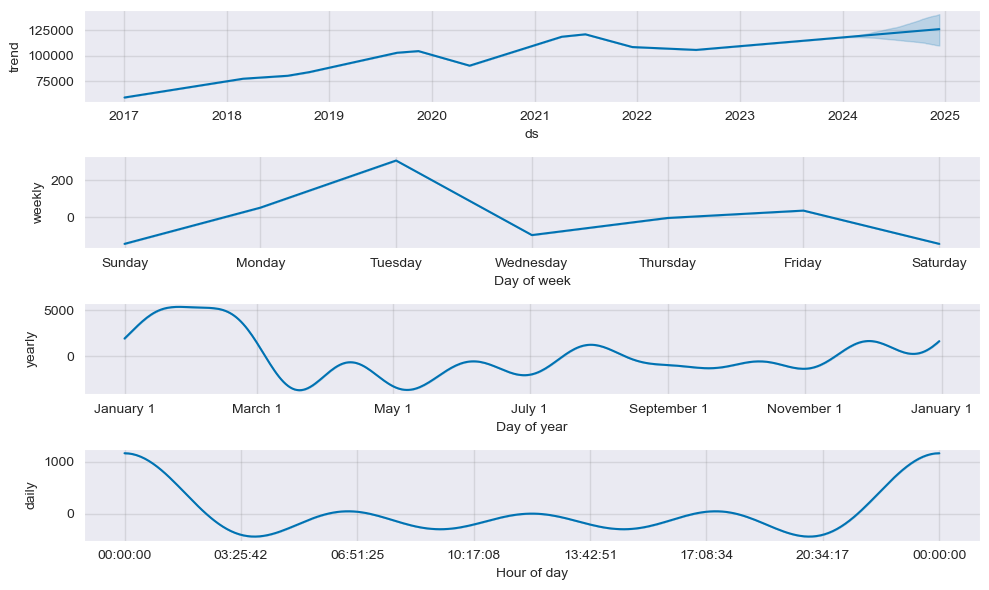

In [76]:
modelo.plot_components(previsao, figsize=(10,6))

In [77]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 4.57%


Dessa forma este foi o modelo que melhor performou dentre nossas tentativas, desconsiderando o modelo 4 pois este apesar de apresentar um excelente resultado pode apresentar algumas falhas na predição causadas pelos comportamentos mencionados anteriormente.